# Trial 2

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# POSITIVE  = r'/home/tsdhrm/Pictures/thesis/100Dataset/Positive'
POSITIVE = r'/Users/teguhsatya/Dev/segeralulus/Dataset/100 Data/Positive'

## Read Images

In [3]:
images = {}
for fname in os.listdir(POSITIVE):
    f = fname.split('.')[0]
    images[f] = cv2.imread(os.path.join(os.path.join(POSITIVE, fname)))
    images[f] = cv2.cvtColor(images[f], cv2.COLOR_BGR2RGB)

## Preprocessing Functions

In [4]:
def resize_all(imgs, prcnt=50):
    resized = {}
    for img in imgs:
        resized[img] = cv2.resize(imgs[img], (int(imgs[img].shape[1]*prcnt/100), int(imgs[img].shape[0]*prcnt/100)), cv2.INTER_AREA)
    return resized

def display_all(imgs, subs, use_gray=False):
    fig, axs = plt.subplots(subs[0], subs[1], figsize=(18, 10))
    k = 0
    for i in range(subs[0]):
        for j in range(subs[1]):
            axs[i, j].imshow(list(imgs.values())[k], 'gray' if use_gray else None)
            axs[i, j].set_title(list(imgs.keys())[k])
            axs[i, j].axis('off')
            k+=1
            
def display_all_with(imgs, subs, cc, use_gray=True):
    fig, axs = plt.subplots(subs[0], subs[1], figsize=(18, 10))
    k = 0
    for i in range(subs[0]):
        for j in range(subs[1]):
            axs[i, j].imshow(list(imgs.values())[k][:,:,cc], cmap='gray' if use_gray else None)
            axs[i, j].set_title(list(imgs.keys())[k])
            axs[i, j].axis('off')
            k+=1
            
def convert_all(imgs, cvt):
    cvtd= {}
    for img in imgs:
        cvtd[img] = cv2.cvtColor(imgs[img], eval(cvt))
    return cvtd

def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)

def adjust_gamma2(image, gamma=1.0):
    table = np.array([((i / 255.0) ** gamma) * 255
      for i in np.arange(0, 256)]).astype("uint8")

    return cv2.LUT(image, table)

## ROI Extractions

In [73]:
def get_the_roi(imgs):
    rois = {}
    wlim = 140
    for img in imgs:
        if imgs[img].shape[0] > 400:
            cropped = imgs[img][130:-50,200:-165]
            gray_img= cv2.cvtColor(cropped, cv2.COLOR_RGB2GRAY)
            xmax = cv2.minMaxLoc(gray_img)[3][0]
            ymax = cv2.minMaxLoc(gray_img)[3][1]
            # rois[img] = cropped[ymax-170:ymax+200, xmax-170:cropped.shape[1]-(cropped.shape[1]-(xmax+150))]
            # rois[img] = cropped[:, xmax:cropped.shape[1]-(cropped.shape[1]-(xmax+150))]
            rois[img] = cropped[ymax-180:ymax+180, 
                                abs(xmax-180)
                                :cropped.shape[1]-(cropped.shape[1]-(xmax+180))]
        else:
            rois[img] = imgs[img]
    display_all(rois, (10,10), True)
    return rois

## Vessel Removal

In [6]:
def remove_vessels(imgs):
    no_vsl = {}
    hsv_c = {}
    clahe = cv2.createCLAHE(2.5, (8,8))
    for img in imgs:
        print(img, imgs[img].shape)
    # display_all_with(hsv_c, (5,10), 2, True)
    # for img in imgs:
    #     g = imgs[img][:,:,1].copy()
    #     gcl = clahe.apply(g)
    #     g_inv = 255-gcl
    #     g_gamma = adjust_gamma2(g_inv.copy(), 5.0)
    #     g_blur = cv2.medianBlur(g_gamma, 5)
    #     ret, th = cv2.threshold(g_blur.copy(),0,255,
    #                             cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #     no_vsl[img] = cv2.inpaint(imgs[img].copy(), th, 10,cv2.INPAINT_TELEA)
    return no_vsl

## Segmentation

In [7]:
def get_which_ellipse(contours):
    conts = np.array([contour.shape[0] for contour in contours])
    cont_idx = np.argmax(conts)
    ellipse = cv2.fitEllipse(contours[cont_idx])
    return ellipse

def extract_od(imgs):
    # tidak harus ada drawn_roi
    drawn_roi = {}
    ods = {}
    gmcs = {}
    closing_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (55,55))
    erosion_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10,10))
    # clahe = cv2.createCLAHE(3, (8,8))
    for img in imgs:
        red = imgs[img][:,:,0]
        gmcr = adjust_gamma2(red, 3.0)
        # gmclahe = clahe.apply(gmcr)
        # gmcr_bl = cv2.GaussianBlur(gmclahe, (15,15), 0)
        # gmcr_bl = cv2.GaussianBlur(gmcr, (15,15), 0)
        opened = cv2.morphologyEx(gmcr, cv2.MORPH_OPEN, kernel=closing_kernel)
        # gmcs[img] = cv2.erode(closing.copy(), kernel=erosion_kernel)
#         erosion = cv2.erode(gmcr_bl.copy(), kernel=np.ones((10,10), np.uint8))
#         dilation = cv2.dilate(erosion, kernel=np.ones((10,10), np.uint8))
        blurred = cv2.GaussianBlur(opened, (15,15), 0)
        ret2, gmcs[img] = cv2.threshold(blurred,0,255,
                                  cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#         cont, hcy = cv2.findContours(th2.copy(), 
#                                      cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#         ellipse = get_which_ellipse(cont)
            
#         od = np.zeros_like(th2, dtype='uint8')
#         cv2.ellipse(od, ellipse, (255, 255, 255), -1)
#         ods[img] = od
#         drawn_roi[img] = ellipse
    display_all(gmcs, (5,10), True)

    # return drawn_roi, ods
    return 0,0

# Main

In [50]:
rsz_imgs = resize_all(images)

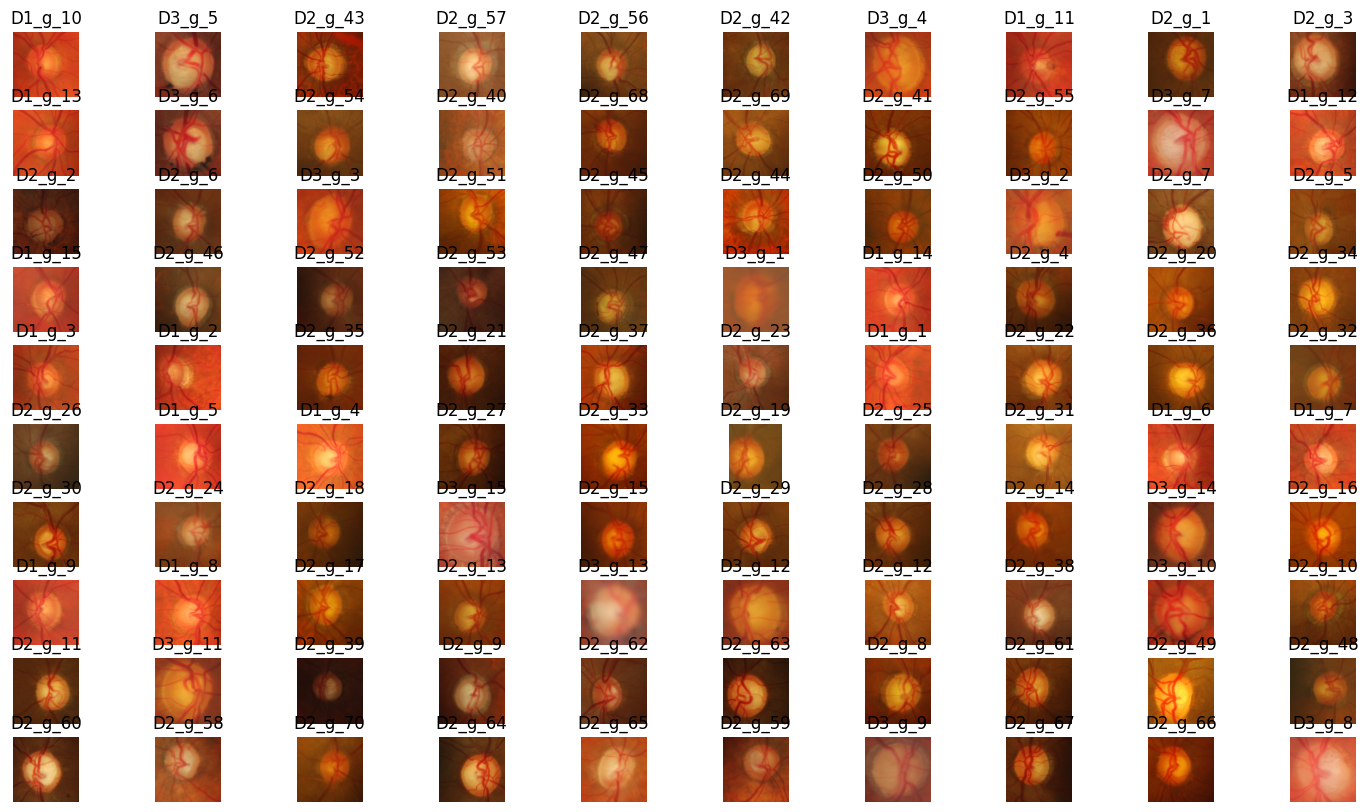

In [74]:
all_roi = get_the_roi(rsz_imgs.copy())

In [68]:
wo_vsl = remove_vessels(all_roi.copy())

D1_g_10 (340, 430, 3)
D3_g_5 (326, 326, 3)
D2_g_43 (340, 430, 3)
D2_g_57 (340, 430, 3)
D2_g_56 (340, 430, 3)
D2_g_42 (340, 430, 3)
D3_g_4 (336, 336, 3)
D1_g_11 (340, 430, 3)
D2_g_1 (340, 430, 3)
D2_g_3 (340, 430, 3)
D1_g_13 (340, 419, 3)
D3_g_6 (321, 321, 3)
D2_g_54 (340, 430, 3)
D2_g_40 (340, 430, 3)
D2_g_68 (340, 430, 3)
D2_g_69 (340, 430, 3)
D2_g_41 (340, 430, 3)
D2_g_55 (340, 430, 3)
D3_g_7 (393, 393, 3)
D1_g_12 (340, 416, 3)
D2_g_2 (340, 430, 3)
D2_g_6 (340, 430, 3)
D3_g_3 (396, 396, 3)
D2_g_51 (340, 430, 3)
D2_g_45 (340, 430, 3)
D2_g_44 (340, 430, 3)
D2_g_50 (340, 430, 3)
D3_g_2 (275, 275, 3)
D2_g_7 (340, 430, 3)
D2_g_5 (340, 430, 3)
D1_g_15 (340, 430, 3)
D2_g_46 (340, 430, 3)
D2_g_52 (340, 430, 3)
D2_g_53 (340, 430, 3)
D2_g_47 (340, 430, 3)
D3_g_1 (326, 326, 3)
D1_g_14 (340, 419, 3)
D2_g_4 (340, 430, 3)
D2_g_20 (340, 430, 3)
D2_g_34 (340, 430, 3)
D1_g_3 (340, 430, 3)
D1_g_2 (340, 430, 3)
D2_g_35 (340, 430, 3)
D2_g_21 (340, 430, 3)
D2_g_37 (340, 430, 3)
D2_g_23 (340, 430, 3)
D1_g

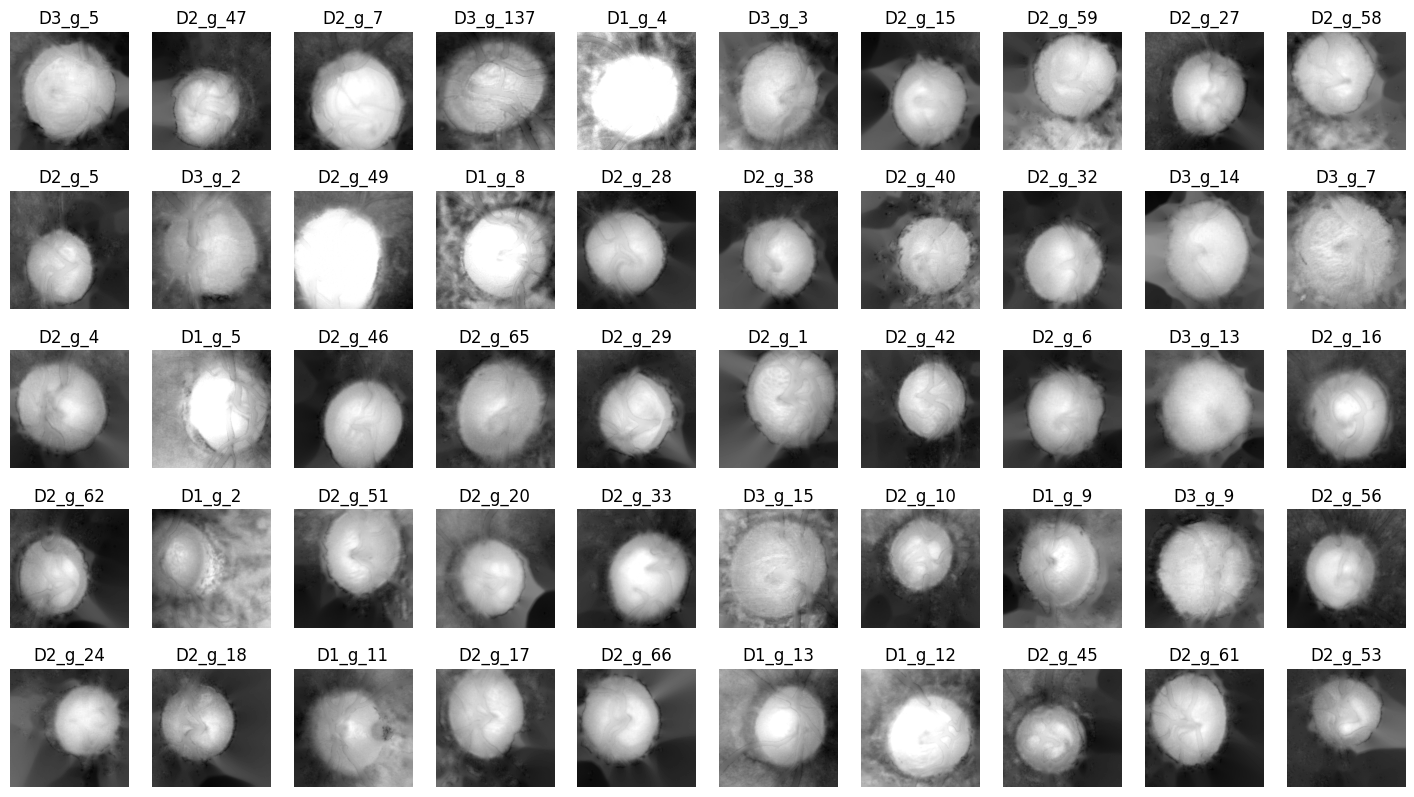

In [81]:
display_all_with(wo_vsl, (5,10), 0, True)

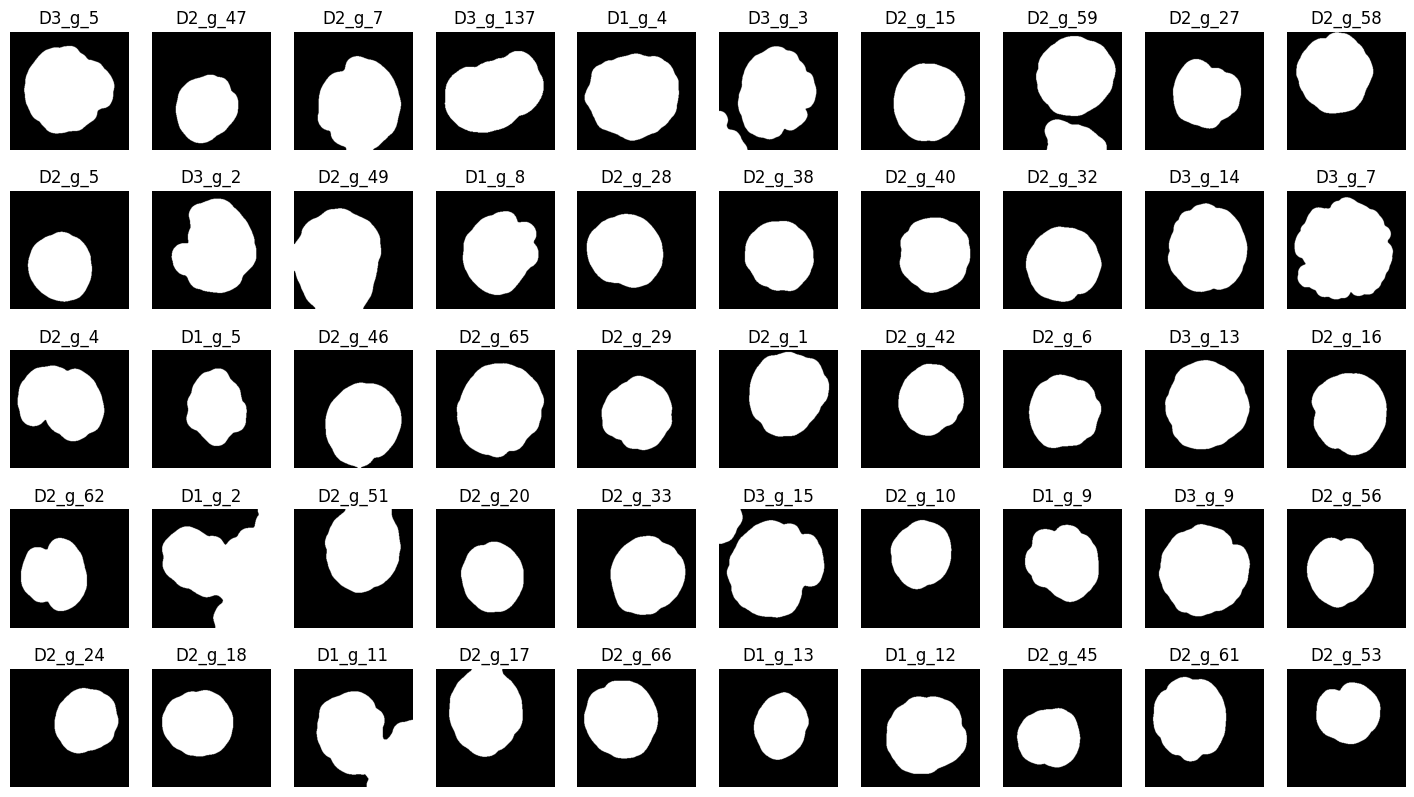

In [115]:
od_line, all_od = extract_od(wo_vsl.copy())

AttributeError: 'int' object has no attribute 'values'

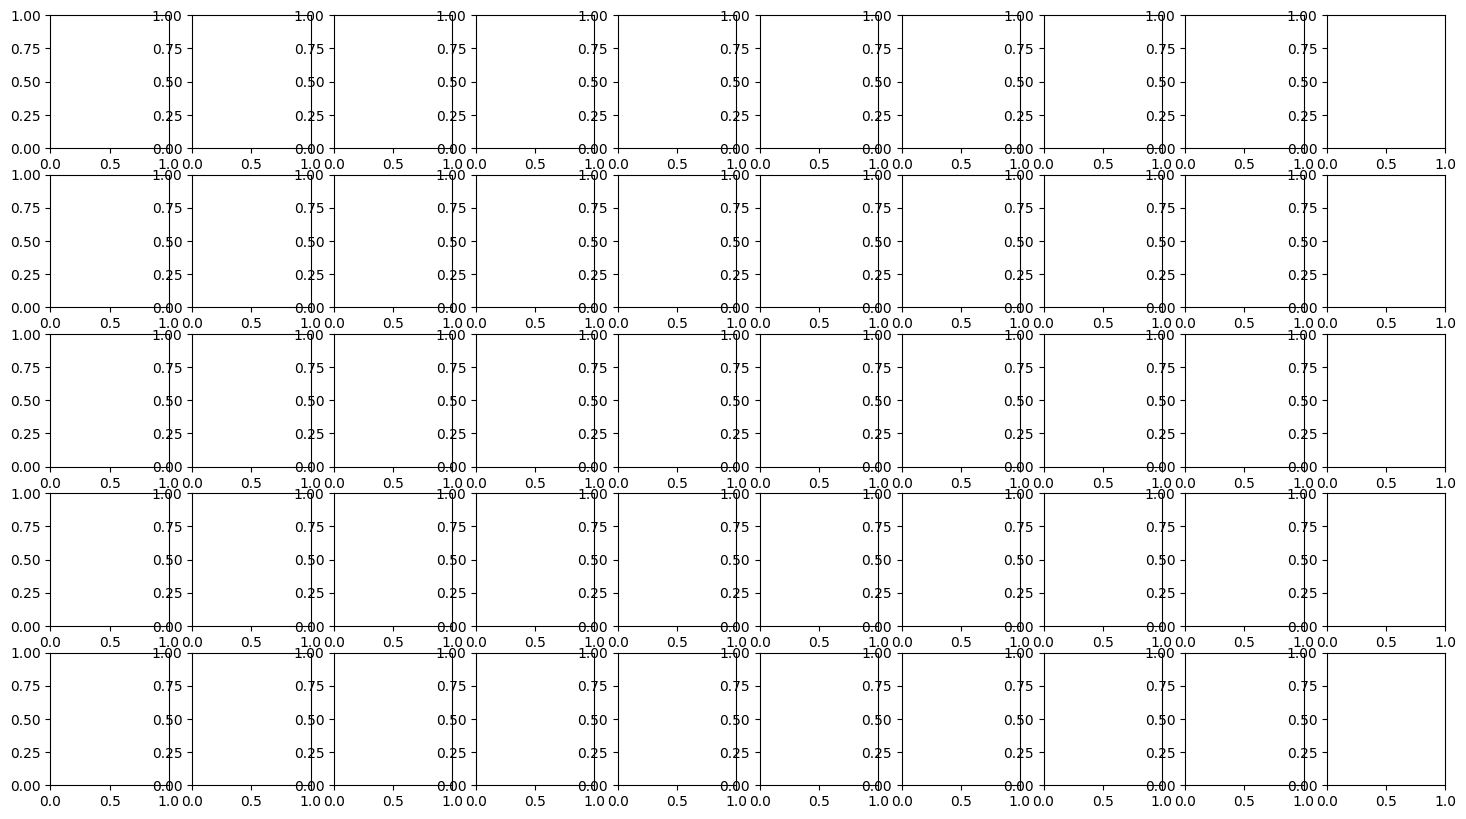

In [83]:
display_all(all_od, (5,10), True)